# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


Populating the interactive namespace from numpy and matplotlib


/nfshome/shy256/.conda/envs/tf/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


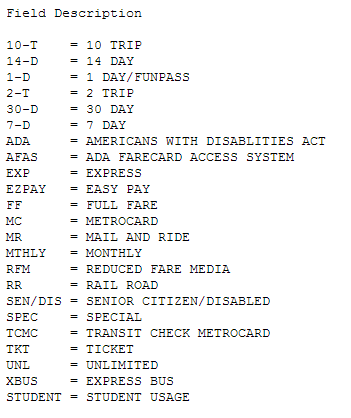

In [252]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
%pylab inline

from IPython.display import Image
from IPython.display import clear_output
from copy import deepcopy
from itertools import product
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

In [4]:
MTA_Fare = np.load("MTA_Fare.npy")
MTA_Fare #.[MTA_Fare < 0.0] = np.nan

array([[[56961, 64703, 68002, ..., 36527, 33929, 36824],
        [ 1732,  2083,  2107, ...,  1264,  1172,  1238],
        [  203,   276,   245, ...,   186,   167,   167],
        ...,
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [   -1,    -1,    -1, ...,  1121,  1377,   712]],

       [[16210, 20179, 21769, ...,    -1,    -1,    -1],
        [  503,   647,   665, ...,    -1,    -1,    -1],
        [   41,    43,    44, ...,    -1,    -1,    -1],
        ...,
        [    0,     0,     0, ...,    -1,    -1,    -1],
        [    0,     0,     0, ...,    -1,    -1,    -1],
        [   -1,    -1,    -1, ...,    -1,    -1,    -1]],

       [[ 3292,  3429,  3629, ...,  3746,  3406,  3217],
        [  110,    92,   102, ...,   212,   209,   211],
        [    7,     6,    13, ...,    26,    20,    22],
        ...,
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,    

In [5]:
MTA_Fare = MTA_Fare.astype(float)
MTA_Fare[MTA_Fare < 0.0] = np.nan
mta = MTA_Fare

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [6]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [7]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

In [19]:
# plot the data in natural space
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)
di = pd.date_range(start='20100521', periods=194, freq='W')

In [36]:
mta.shape

(600, 23, 194)

/nfshome/shy256/.conda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


Text(0,0.5,'swipes ($log_{10}$)')

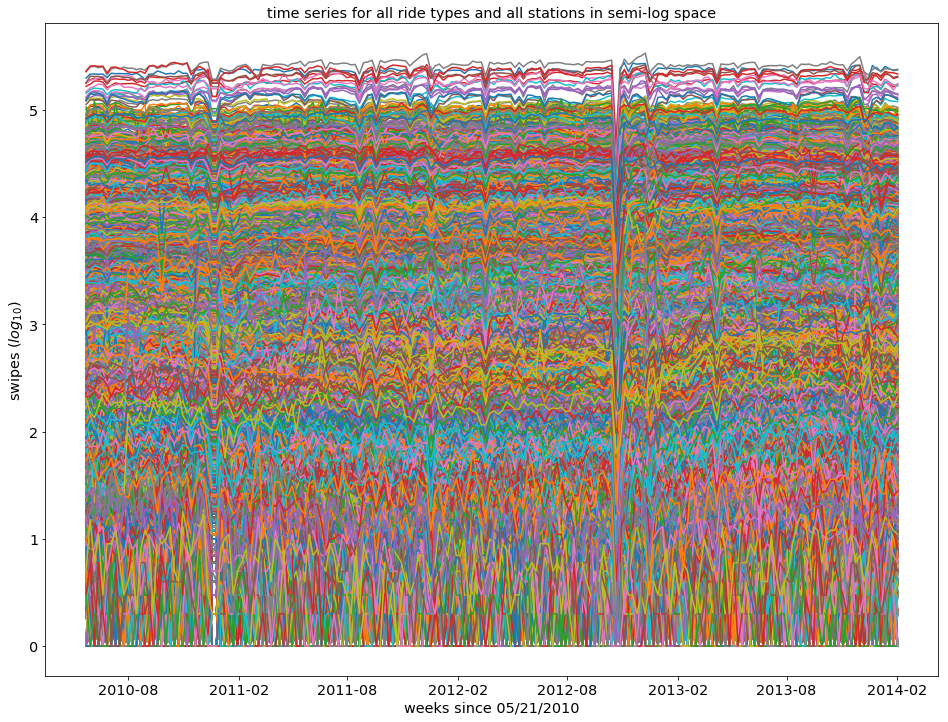

In [50]:
fig = plt.figure(figsize=(16, 12))
ax = plt.gca()
for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        plt.plot(di, np.log10(mta[i][j]))
ax.set_title('time series for all ride types and all stations in semi-log space')
ax.set_xlabel('weeks since 05/21/2010')
ax.set_ylabel('swipes ($log_{10}$)')


#### Figure 2: time series for all ride types and all stations in semi-log space

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



#### I will look at the latter six months 2012

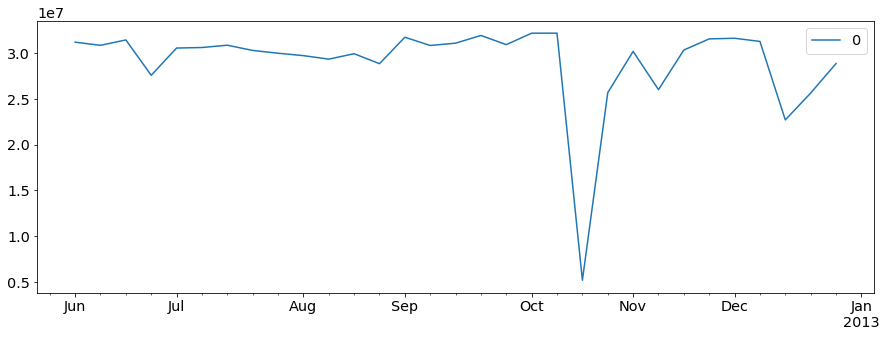

In [90]:
df = pd.DataFrame(np.nansum(np.nansum(mta, axis=0), axis=0), index=di)
df = df[('2012-06-01' < df.index) & (df.index < '2013-01-01')]
df.plot()

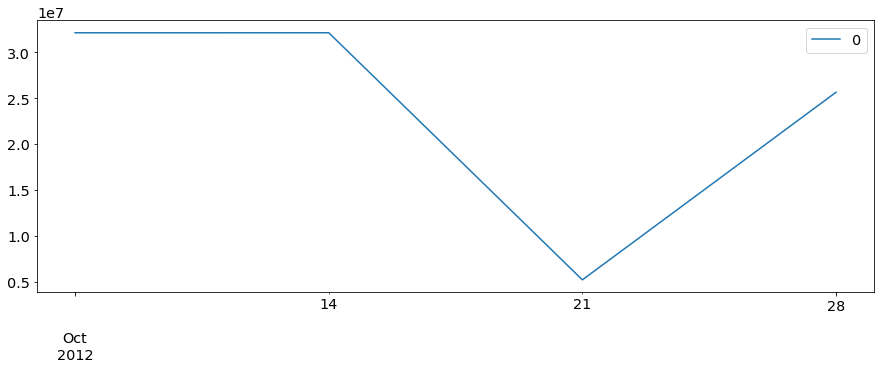

In [91]:
df = pd.DataFrame(np.nansum(np.nansum(mta, axis=0), axis=0), index=di)
df = df[('2012-10-01' < df.index) & (df.index < '2012-10-31')]
df.plot()

#### October 22 to 28 is when hurricane Sandy hit NY

 # 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


13
stdev 16498.07, fractional change over time 0.60: 
14
stdev 145035.47, fractional change over time 0.66: 


//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  if __name__ == '__main__':


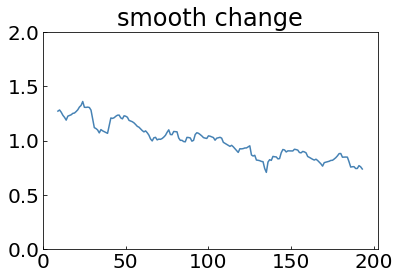

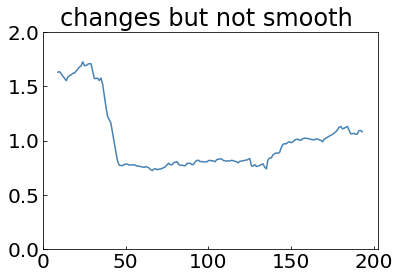

In [129]:
# examples of 2 time series with comparable change ratio, but only one of them has a smooth trend

In [92]:
mta.shape

(600, 23, 194)

In [104]:
df = np.nanmean(mta, axis=0)
df.shape

/nfshome/shy256/.conda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


(23, 194)

In [105]:
df = pd.DataFrame(df.T, index=di, columns=ridetype)
df.head()

,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,umlim,xbus,stud
2010-05-23,24880.119048,1148.320346,103.465368,403.790043,101.316017,8003.123377,18510.686147,21.781385,721.205628,1108.294372,...,266.523810,1710.194805,129.456710,61.084416,0.00000,269.898268,45.584416,13.264069,0.774892,NaN
2010-05-30,27173.229935,1265.798265,111.683297,432.167028,139.594360,8637.327549,20577.861171,25.698482,613.351410,1253.845987,...,329.605206,1969.778742,150.127983,70.136659,0.00000,264.019523,47.006508,13.275488,1.028200,NaN
2010-06-06,27573.708423,1266.077754,111.524838,431.248380,123.097192,8710.647948,20467.684665,26.516199,652.328294,1329.453564,...,327.295896,1974.349892,150.267819,70.449244,0.00000,263.889849,46.291577,14.017279,1.004320,NaN
2010-06-13,27329.751620,1215.123110,112.447084,424.166307,80.840173,8710.049676,20410.542117,24.235421,659.855292,1309.438445,...,317.697624,1949.349892,147.082073,69.987041,0.00000,263.609071,46.717063,14.233261,1.045356,NaN
2010-06-20,27607.099138,1182.883621,110.243534,420.006466,75.883621,8460.012931,20030.176724,22.661638,723.663793,1214.323276,...,297.172414,1843.907328,143.053879,68.821121,0.37931,258.137931,43.743534,13.605603,0.974138,NaN


In [115]:
df_stdz = deepcopy(df)
for c in df.columns:
    df_stdz[c] = (df_stdz[c] - df_stdz[c].mean()) / df_stdz[c].std()
df_stdz.head()

,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,umlim,xbus,stud
2010-05-23,-1.434783,-1.063802,-1.144591,-0.050522,-0.142957,-1.439578,-0.397228,2.016594,2.569034,1.867764,...,0.643549,1.568532,-1.615268,-1.775036,-2.281779,-0.798000,-0.185819,-0.249220,-1.431272,NaN
2010-05-30,-0.574722,-0.477530,-0.637422,0.711692,1.257267,-1.057596,0.509548,2.462533,2.119322,2.171893,...,1.881662,2.272575,-1.368638,-1.575377,-2.281779,-0.875906,0.039592,-0.244028,-1.052882,NaN
2010-06-06,-0.424517,-0.476135,-0.647201,0.687017,0.653800,-1.013435,0.461219,2.555626,2.281841,2.329874,...,1.836337,2.284973,-1.366969,-1.568483,-2.281779,-0.877625,-0.073729,0.093299,-1.088554,NaN
2010-06-13,-0.516016,-0.730424,-0.590285,0.496791,-0.891965,-1.013795,0.436153,2.295972,2.313226,2.288053,...,1.647949,2.217168,-1.404979,-1.578677,-2.281779,-0.881346,-0.006287,0.191517,-1.027253,NaN
2010-06-20,-0.411994,-0.891315,-0.726277,0.385056,-1.073276,-1.164393,0.269304,2.116806,2.579283,2.089311,...,1.245096,1.931187,-1.453039,-1.604393,-2.267294,-0.953851,-0.477610,-0.093909,-1.133639,NaN


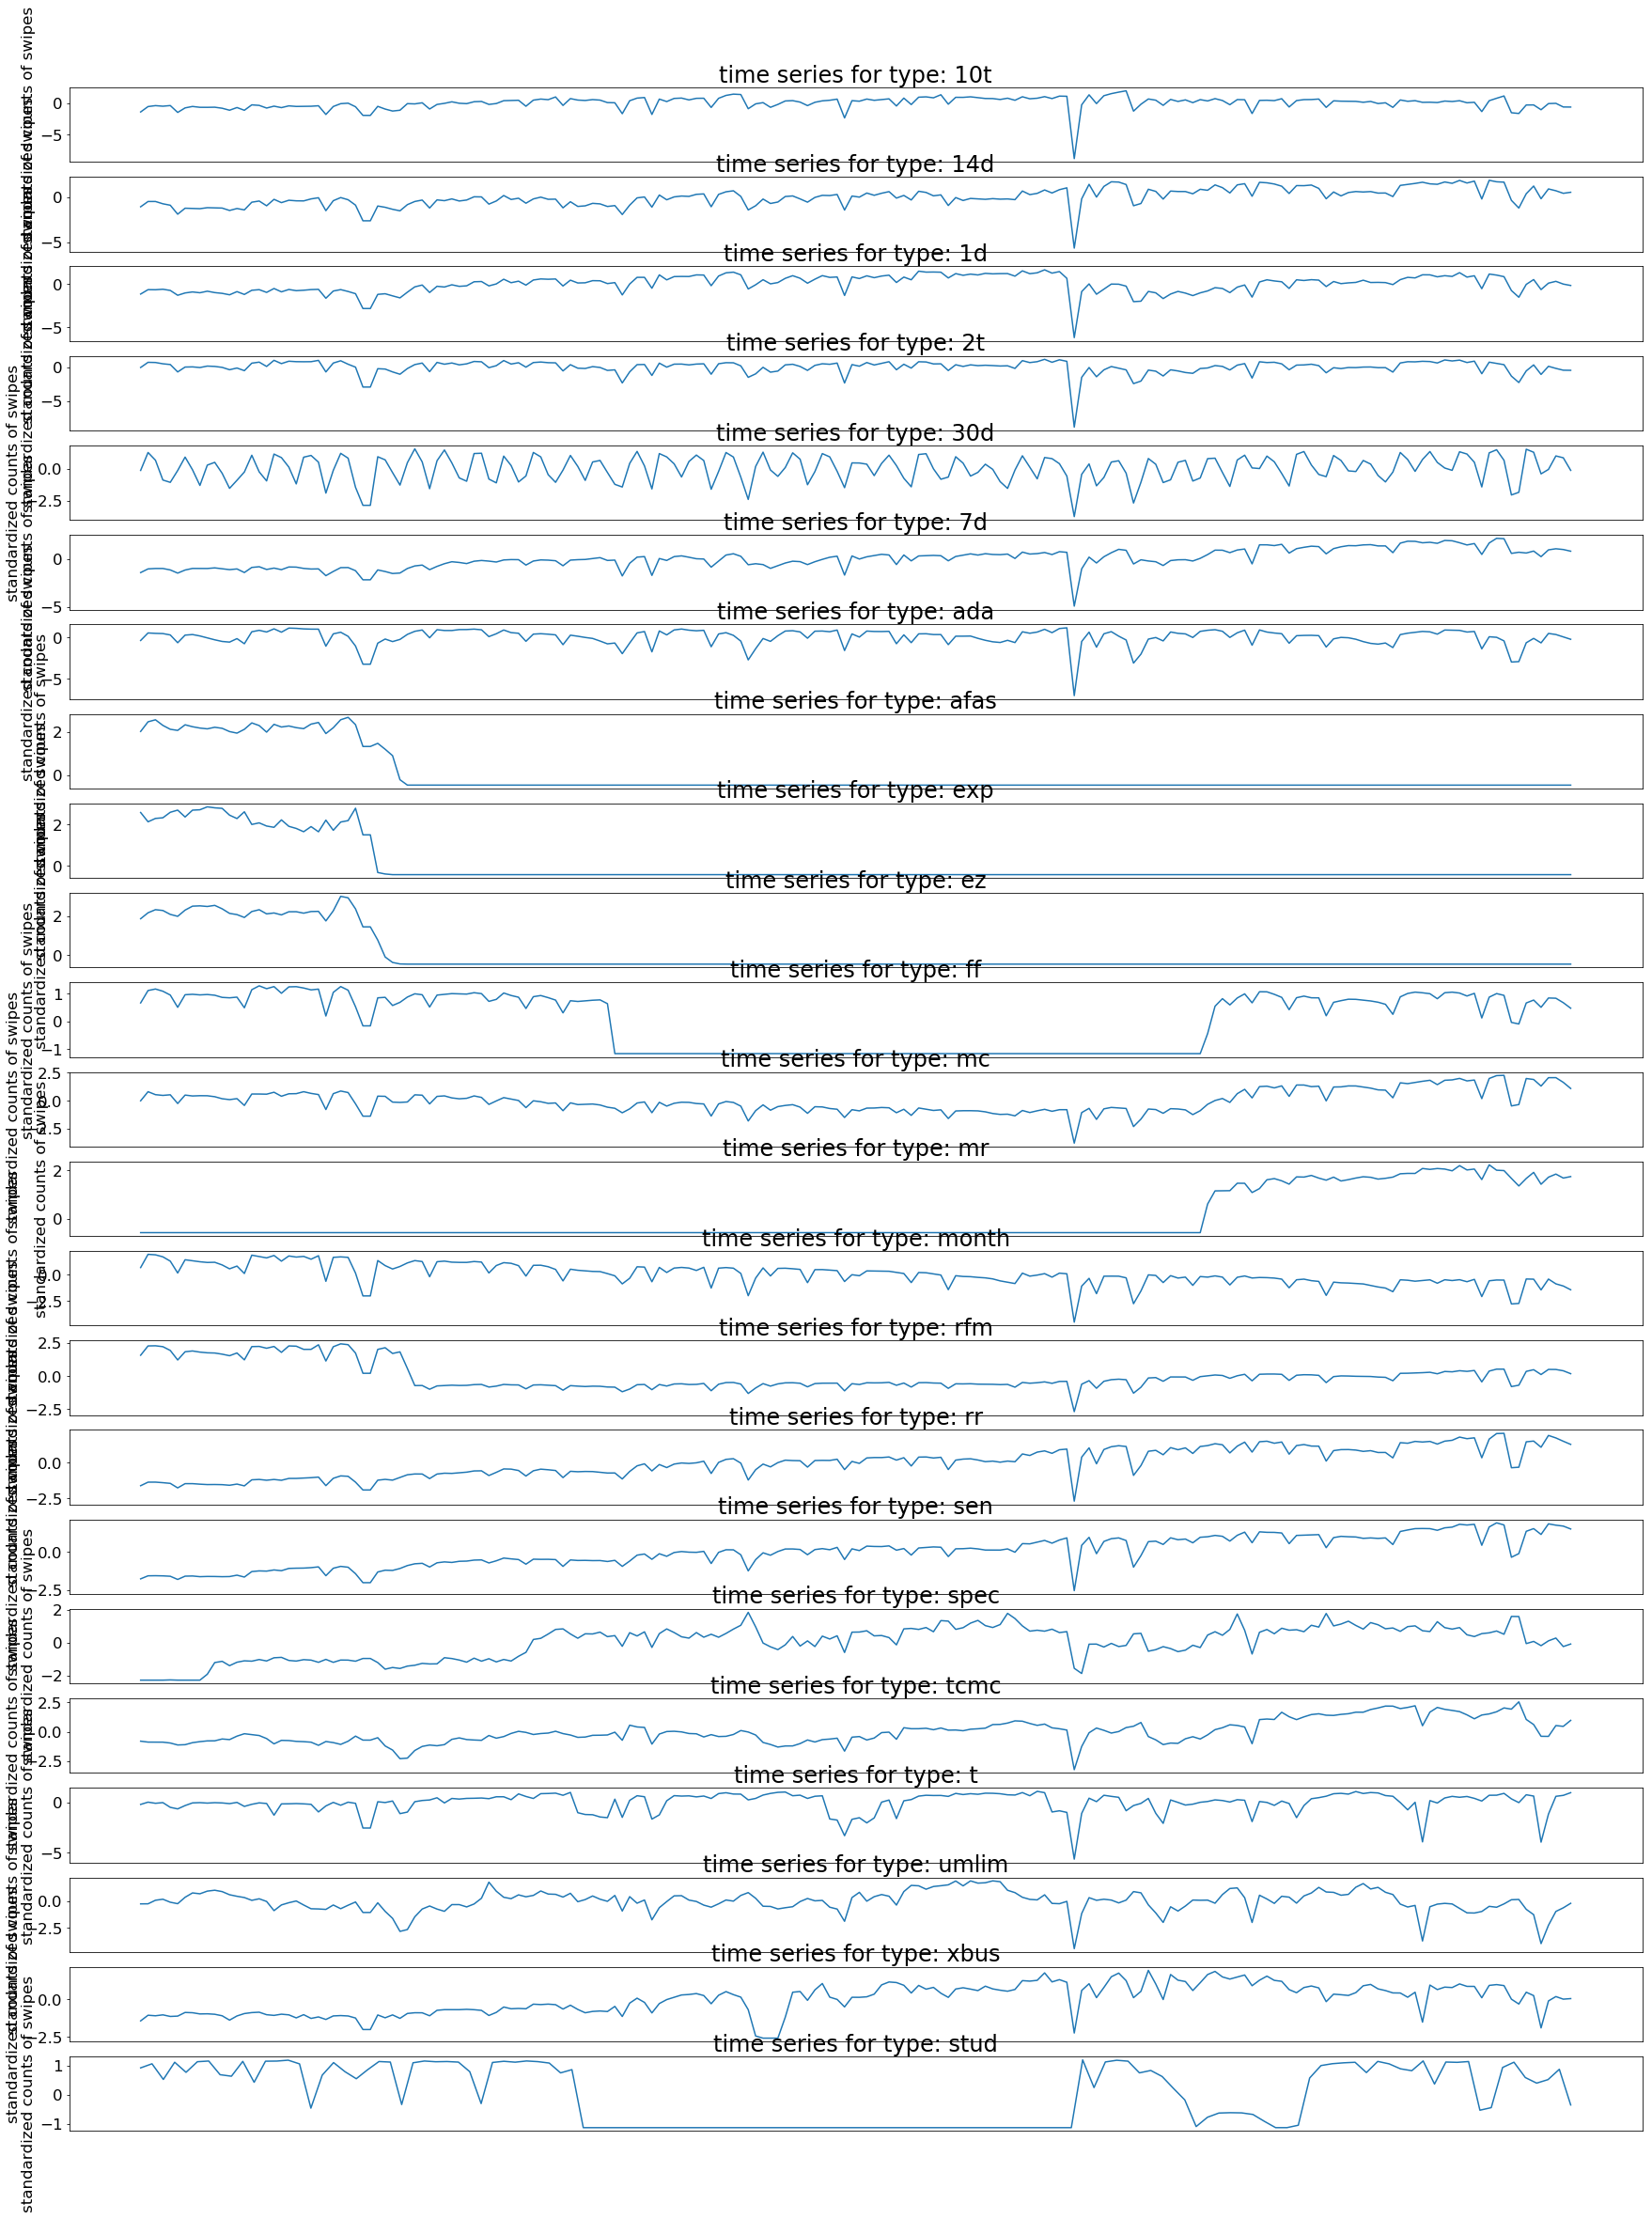

In [158]:
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'small',
         'axes.titlesize':'large',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
plt.rcParams.update(params)

f, axs = plt.subplots(
    len(df_stdz.columns)
    , 1
    , figsize=(30, 40)
)

for i, c in enumerate(df_stdz.columns):
    ax = axs[i]
    ax.set_title('time series for type: %s' % c)
    ax.set_xlabel('weeks since 05/21/2010')
    ax.set_ylabel('standardized counts of swipes')
    ax.get_xaxis().set_visible(False)
    ax.plot(di, df_stdz[c])



* increase: 7d, ff, mc, mr, rr, sen, tcmc
* decrease: month, 

In [224]:
stat_df = pd.DataFrame(
    np.zeros((23, 5))
    , columns = ['mean', 'std', 'median', 'count', 'sum']
    , index = df.columns
)
stat_df.head()

,mean,std,median,count,sum
10t,0.0,0.0,0.0,0.0,0.0
14d,0.0,0.0,0.0,0.0,0.0
1d,0.0,0.0,0.0,0.0,0.0
2t,0.0,0.0,0.0,0.0,0.0
30d,0.0,0.0,0.0,0.0,0.0


In [225]:
stat_df['start_to_end_increase_percent_mean'] = df.iloc[[0, -1], :].T.apply(lambda row: row[1] - row[0], axis=1) / df.mean()

In [226]:
for c in df.columns:
    ops = ['mean', 'std', 'median', 'count', 'sum']
    print(c)
    for op in ops:
        stat_df.loc[c, op] = eval("df['%s'].%s()" % (c, op))
stat_df['mean_to_std_ratio'] = stat_df['mean'] / stat_df['std']
stat_df.sort_values(by='start_to_end_increase_percent_mean', ascending=False)

10t
14d
1d
2t
30d
7d
ada
afas
exp
ez
ff
mc
mr
month
rfm
rr
sen
spec
tcmc
t
umlim
xbus
stud


,mean,std,median,count,sum,start_to_end_increase_percent_mean,mean_to_std_ratio
mr,79.532648,137.020134,0.006466,194.0,1.542933e+04,3.982927,0.580445
sen,141.561971,45.338545,145.941685,194.0,2.746302e+04,1.049913,3.122332
spec,59.752276,26.186707,68.956803,194.0,1.159194e+04,0.960278,2.281779
rr,264.839954,83.814712,269.116453,194.0,5.137895e+04,0.907556,3.159827
xbus,1.733037,0.669436,1.832613,194.0,3.362091e+02,0.577022,2.588801
tcmc,330.114311,75.458728,317.484914,194.0,6.404218e+04,0.404353,4.374766
7d,10393.251445,1660.297236,10314.514039,194.0,2.016291e+06,0.355632,6.259874
mc,259.868071,63.806572,250.233404,194.0,5.041441e+04,0.270542,4.072748
14d,1361.486294,200.381166,1354.788800,194.0,2.641283e+05,0.236839,6.794482
t,46.756728,6.308900,48.255935,194.0,9.070805e+03,0.157720,7.411233


the graph shows that, for example, even though xbus seems like a gradual increaser, it is not because it fluctuates to reach its peak in the middle of the date range. However, the top and bottom several types with low mean to std ratio usually are the ones with the gradual increase, decrease respectively.  

* increase: 7d, ff, mc, mr, rr, sen, tcmc
* decrease: month,

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [604]:
nonull = deepcopy(mta)
nonull = nonull.reshape(600 * 23, 194)
nonull.T

array([[56961.,  1732.,   203., ...,    nan,    nan,    nan],
       [64703.,  2083.,   276., ...,    nan,    nan,    nan],
       [68002.,  2107.,   245., ...,    nan,    nan,    nan],
       ...,
       [36527.,  1264.,   186., ...,    nan,    nan,    nan],
       [33929.,  1172.,   167., ...,    nan,    nan,    nan],
       [36824.,  1238.,   167., ...,    nan,    nan,    nan]])

In [605]:
nonull_df = pd.DataFrame(
    nonull.T
    , index=di
    , columns=[c % 600 for c in range(len(ridetype) * 600)]
)
nonull_df.head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
2010-05-23,56961.0,1732.0,203.0,883.0,358.0,17654.0,32369.0,59.0,6733.0,1835.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-30,64703.0,2083.0,276.0,958.0,529.0,20249.0,42599.0,60.0,5487.0,2320.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-06,68002.0,2107.0,245.0,976.0,422.0,20325.0,41423.0,67.0,6237.0,2521.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-13,72628.0,2188.0,280.0,987.0,261.0,20852.0,42667.0,61.0,7272.0,2759.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-20,75866.0,2314.0,265.0,1012.0,248.0,20079.0,42415.0,51.0,7752.0,2673.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### remember index to ticket type 

In [606]:
nonull_df_tix = deepcopy(nonull_df)
nonull_df_tix.columns = ['%d|%s' % (c, ridetype[i % 23]) for i, c in enumerate(nonull_df.columns)]
nonull_df_tix.head()

,0|10t,1|14d,2|1d,3|2t,4|30d,5|7d,6|ada,7|afas,8|exp,9|ez,...,590|month,591|rfm,592|rr,593|sen,594|spec,595|tcmc,596|t,597|umlim,598|xbus,599|stud
2010-05-23,56961.0,1732.0,203.0,883.0,358.0,17654.0,32369.0,59.0,6733.0,1835.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-30,64703.0,2083.0,276.0,958.0,529.0,20249.0,42599.0,60.0,5487.0,2320.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-06,68002.0,2107.0,245.0,976.0,422.0,20325.0,41423.0,67.0,6237.0,2521.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-13,72628.0,2188.0,280.0,987.0,261.0,20852.0,42667.0,61.0,7272.0,2759.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-20,75866.0,2314.0,265.0,1012.0,248.0,20079.0,42415.0,51.0,7752.0,2673.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [607]:
nonull_df = nonull_df.dropna(axis=1)
nonull_df.shape

(194, 9174)

In [608]:
nonull_df_tix = nonull_df_tix.dropna(axis=1)
nonull_df_tix.shape

(194, 9174)

In [609]:
x = map(
    lambda i: nonull_df[i].sum(axis=1).mean(axis=0)
    , range(600)
)
y = map(
    lambda i: nonull_df[i].sum(axis=1).std(axis=0)
    , range(600)
)
stations_stat = pd.DataFrame(
    data={
        'mean': list(x), 'std': list(y)
    }
    , index=range(600)
)

In [610]:
stations_stat.head()

,mean,std
0,40678.726804,4688.515138
1,70584.020619,8590.085871
2,32377.108247,3858.709239
3,27849.773196,2668.786159
4,52224.670103,7567.061171


In [611]:
stationsmeans = stations_stat['mean']
stationsmeans.shape

(600,)

In [612]:
stationsstd = stations_stat['std']
stationsstd.shape

(600,)

you will have to remove time series containing NaN because the random forest sklearn implementation does not work with NaNs. 
An easy way to do that is to remove all time series whose standard deviation is NaN
Here is how you would use to only extract station id for the valid (no containing nan) time series


In [613]:
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
stationid[mta.reshape(600*23, 194).std(1) > 0]

/nfshome/shy256/.conda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


array([  2,   2,   2, ..., 550, 550, 550])

In [614]:
nonull_df.shape

(194, 9174)

In [615]:
nonull_df = nonull_df.T
nonull_df.head()

,2010-05-23 00:00:00,2010-05-30 00:00:00,2010-06-06 00:00:00,2010-06-13 00:00:00,2010-06-20 00:00:00,2010-06-27 00:00:00,2010-07-04 00:00:00,2010-07-11 00:00:00,2010-07-18 00:00:00,2010-07-25 00:00:00,...,2013-12-01 00:00:00,2013-12-08 00:00:00,2013-12-15 00:00:00,2013-12-22 00:00:00,2013-12-29 00:00:00,2014-01-05 00:00:00,2014-01-12 00:00:00,2014-01-19 00:00:00,2014-01-26 00:00:00,2014-02-02 00:00:00
46,3292.0,3429.0,3629.0,2808.0,3614.0,2601.0,2848.0,2798.0,2888.0,3591.0,...,3506.0,2894.0,2679.0,3337.0,3599.0,3273.0,3418.0,3746.0,3406.0,3217.0
47,110.0,92.0,102.0,79.0,93.0,74.0,72.0,92.0,97.0,95.0,...,192.0,167.0,160.0,180.0,204.0,166.0,191.0,212.0,209.0,211.0
48,7.0,6.0,13.0,7.0,5.0,7.0,7.0,6.0,3.0,4.0,...,21.0,17.0,18.0,20.0,19.0,13.0,19.0,26.0,20.0,22.0
49,41.0,51.0,47.0,37.0,50.0,43.0,44.0,32.0,43.0,57.0,...,25.0,18.0,24.0,20.0,25.0,29.0,31.0,28.0,24.0,22.0
50,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,...,2.0,1.0,1.0,10.0,8.0,6.0,5.0,5.0,6.0,0.0


In [616]:
from sklearn.preprocessing import StandardScaler

nonull_df_stdz = pd.DataFrame(
    data=StandardScaler().fit_transform(nonull_df)
    , index = nonull_df.index
    , columns = nonull_df.columns
)
nonull_df_stdz.head()

,2010-05-23 00:00:00,2010-05-30 00:00:00,2010-06-06 00:00:00,2010-06-13 00:00:00,2010-06-20 00:00:00,2010-06-27 00:00:00,2010-07-04 00:00:00,2010-07-11 00:00:00,2010-07-18 00:00:00,2010-07-25 00:00:00,...,2013-12-01 00:00:00,2013-12-08 00:00:00,2013-12-15 00:00:00,2013-12-22 00:00:00,2013-12-29 00:00:00,2014-01-05 00:00:00,2014-01-12 00:00:00,2014-01-19 00:00:00,2014-01-26 00:00:00,2014-02-02 00:00:00
46,0.048618,0.033584,0.046910,-0.019940,0.050176,-0.010375,-0.010470,-0.018585,-0.008085,0.054882,...,0.009106,0.033328,0.012668,0.026188,0.039787,0.036064,0.016220,0.042917,0.025660,0.014939
47,-0.249182,-0.250473,-0.248545,-0.251005,-0.248452,-0.253295,-0.250937,-0.248362,-0.248668,-0.249454,...,-0.236879,-0.230747,-0.235653,-0.241810,-0.243775,-0.243302,-0.242214,-0.244795,-0.245664,-0.243487
48,-0.258821,-0.257794,-0.256000,-0.257101,-0.255916,-0.259736,-0.256567,-0.255665,-0.256771,-0.257376,...,-0.249572,-0.245273,-0.249652,-0.255393,-0.259227,-0.257059,-0.255989,-0.259937,-0.261704,-0.259735
49,-0.255639,-0.253963,-0.253152,-0.254561,-0.252099,-0.256275,-0.253362,-0.253457,-0.253323,-0.252762,...,-0.249275,-0.245176,-0.249060,-0.255393,-0.258726,-0.255620,-0.255028,-0.259774,-0.261364,-0.259735
50,-0.259477,-0.258304,-0.257089,-0.257694,-0.256255,-0.260312,-0.257174,-0.256174,-0.257029,-0.257550,...,-0.250982,-0.246822,-0.251327,-0.256241,-0.260146,-0.257688,-0.257110,-0.261647,-0.262892,-0.261626


In [617]:
nonull_df_stdz.max().max(), nonull_df_stdz.min().min()

(24.765756073550175, -0.26340122134573946)

Text(0,0.5,'standardized number of rides')

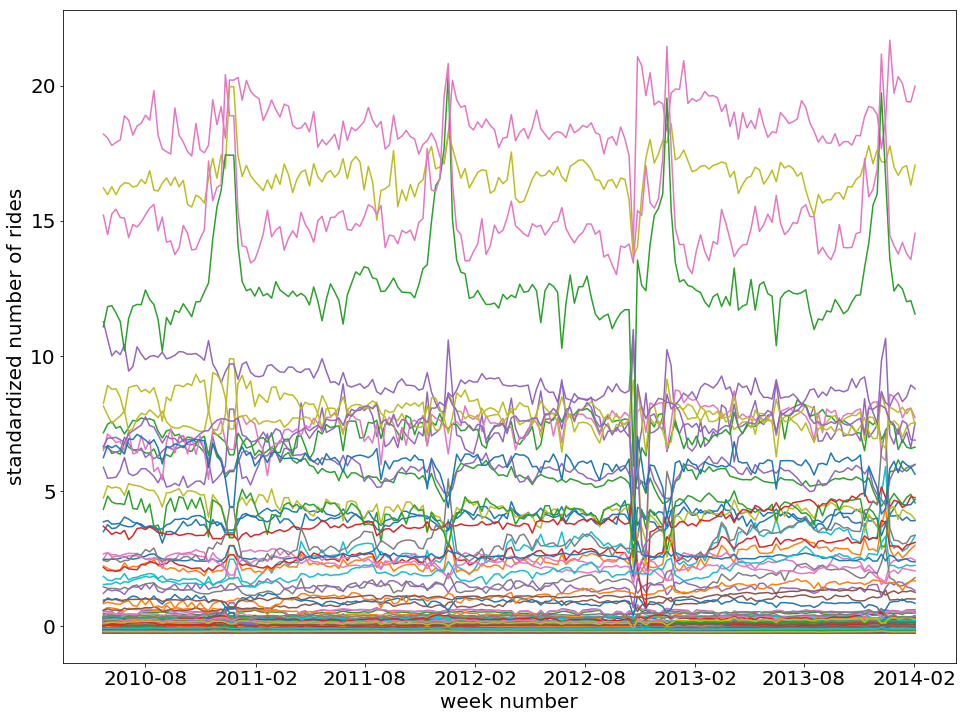

In [618]:
fig = plt.figure(figsize=(16, 12))
for i in range(400):
    pl.plot(nonull_df_stdz.T.iloc[:,i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")

## standardization of the entire dataset begets this kind of plot where the vast majority of time series is sedimented near 0. this is because their data points' values are dwarfed by a few popular station's time series.

In [360]:
normed_time_series_mean = nonull_df_stdz.mean(axis=1)
normed_time_series_std = nonull_df_stdz.std(axis=1)

In [361]:
normed_time_series_mean[:10]

46    0.041753
47   -0.239765
48   -0.250204
49   -0.249165
50   -0.251444
51   -0.109429
52   -0.147639
53   -0.251642
54   -0.251272
55   -0.249072
dtype: float64

In [362]:
normed_time_series_std[:10]

46    0.027981
47    0.005408
48    0.005598
49    0.005536
50    0.005534
51    0.016065
52    0.013202
53    0.005626
54    0.005408
55    0.006698
dtype: float64

#### below is generation of data set that is standardized with respect to each time series of 9174

In [363]:
tsmean = np.nanmean(nonull_df, axis=1)
tsmean.shape



(9174,)

In [365]:
tsstdev = np.nanstd(nonull_df, axis=1)
tsstdev.shape



(9174,)

In [366]:
tsmean[:10]

array([3.54891753e+03, 1.44587629e+02, 1.79381443e+01, 3.02577320e+01,
       2.89690722e+00, 1.72666495e+03, 1.25873711e+03, 3.86597938e-01,
       4.62886598e+00, 3.00618557e+01])

In [367]:
tsstdev[:10]


array([391.40042433,  43.60075488,   8.13711673,   9.80981872,
         4.23530701, 286.20893188, 182.35136007,   1.22685827,
        11.1163663 ,  67.14683317])

In [391]:
np.nanstd(nonull_df, axis=1).shape

(9174,)

In [394]:
nonull_df_stdz = deepcopy(nonull_df)
for c in nonull_df.columns:
    nonull_df_stdz[c] = (nonull_df_stdz[c] - tsmean) / tsstdev
nonull_df_stdz.head()

,2010-05-23 00:00:00,2010-05-30 00:00:00,2010-06-06 00:00:00,2010-06-13 00:00:00,2010-06-20 00:00:00,2010-06-27 00:00:00,2010-07-04 00:00:00,2010-07-11 00:00:00,2010-07-18 00:00:00,2010-07-25 00:00:00,...,2013-12-01 00:00:00,2013-12-08 00:00:00,2013-12-15 00:00:00,2013-12-22 00:00:00,2013-12-29 00:00:00,2014-01-05 00:00:00,2014-01-12 00:00:00,2014-01-19 00:00:00,2014-01-26 00:00:00,2014-02-02 00:00:00
46,-0.656406,-0.306381,0.204605,-1.892991,0.166281,-2.421861,-1.790794,-1.918540,-1.688597,0.107518,...,-0.109651,-1.673267,-2.222577,-0.541434,0.127957,-0.704949,-0.334485,0.503532,-0.365144,-0.848025
47,-0.793281,-1.206117,-0.976764,-1.504277,-1.183182,-1.618954,-1.664825,-1.206117,-1.091440,-1.137311,...,1.087421,0.514036,0.353489,0.812196,1.362645,0.491101,1.064485,1.546129,1.477322,1.523193
48,-1.344229,-1.467122,-0.606867,-1.344229,-1.590016,-1.344229,-1.344229,-1.467122,-1.835803,-1.712909,...,0.376283,-0.115292,0.007602,0.253389,0.130495,-0.606867,0.130495,0.990751,0.253389,0.499176
49,1.095053,2.114439,1.706685,0.687298,2.012501,1.298930,1.400869,0.177605,1.298930,2.726072,...,-0.535966,-1.249537,-0.637905,-1.045660,-0.535966,-0.128212,0.075666,-0.230150,-0.637905,-0.841782
50,-0.683990,-0.683990,-0.683990,-0.683990,-0.447880,-0.447880,-0.683990,-0.683990,-0.683990,-0.211769,...,-0.211769,-0.447880,-0.447880,1.677114,1.204893,0.732672,0.496562,0.496562,0.732672,-0.683990


In [395]:
# nonull_df_stdz.T.shape
nonull_df_stdz.T.head()

,46,47,48,49,50,51,52,53,54,55,...,62,63,64,65,66,67,68,69,70,71
2010-05-23,-0.656406,-0.793281,-1.344229,1.095053,-0.68399,-1.127376,0.467575,-0.315112,2.822067,2.143633,...,NaN,NaN,-0.071982,-0.071982,-0.071982,-2.211459,0.168214,NaN,NaN,NaN
2010-05-30,-0.306381,-1.206117,-1.467122,2.114439,-0.68399,-0.743041,0.467575,0.499978,0.843003,2.471273,...,NaN,NaN,-0.071982,-0.071982,-0.071982,-2.211459,-0.854043,NaN,NaN,NaN
2010-06-06,0.204605,-0.976764,-0.606867,1.706685,-0.68399,-0.522922,0.758222,-0.315112,3.181897,2.471273,...,NaN,NaN,-0.071982,-0.071982,-0.071982,-2.211459,-1.148925,NaN,NaN,NaN
2010-06-13,-1.892991,-1.504277,-1.344229,0.687298,-0.68399,-1.602553,-0.623725,3.760338,1.652620,2.084062,...,NaN,NaN,-0.071982,-0.071982,-0.071982,-2.211459,-0.401891,NaN,NaN,NaN
2010-06-20,0.166281,-1.183182,-1.590016,2.012501,-0.44788,-0.896775,0.588221,7.020699,2.372280,2.218096,...,NaN,NaN,-0.071982,-0.071982,-0.071982,-2.197464,0.679343,NaN,NaN,NaN


Text(0.5,1,'standardized number of rides vs. datetime')

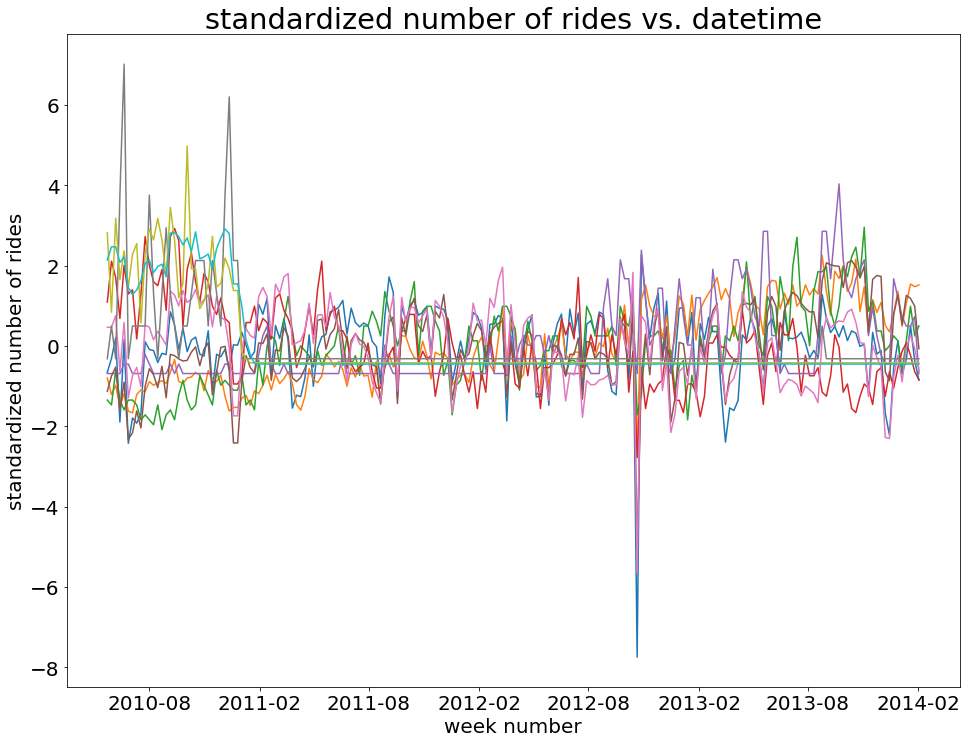

In [400]:
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
plt.rcParams.update(params)

fig = plt.figure(figsize=(16, 12))
for i in range(10):
    pl.plot(nonull_df_stdz.T.iloc[:,i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")
pl.title("standardized number of rides vs. datetime")

### timeseries level data standardization renders this result. The signal detection is easier this way, because the standardization of the entire data set will beget time series data that is a constant outlier, because it is representative of popular spot like grand central station.

#### The feature description does not specify endog/ exog variables for OLS. So I am going to fit average of entire data set collapsed as a single  individual time series

In [408]:
station_sum = nonull_df.groupby(axis=0, level=0).sum()
station_sum = station_sum.T
station_sum.head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
2010-05-23,43676.0,49962.0,27988.0,26150.0,48986.0,37324.0,10054.0,35856.0,7831.0,22408.0,...,63979.0,11321.0,54760.0,23975.0,62656.0,28460.0,79889.0,25132.0,100712.0,41376.0
2010-05-30,47000.0,65956.0,36459.0,27369.0,55574.0,41270.0,10565.0,39567.0,8465.0,23857.0,...,78312.0,12634.0,60312.0,25297.0,66941.0,32595.0,106884.0,27328.0,111482.0,43793.0
2010-06-06,46281.0,66846.0,35932.0,28169.0,58434.0,41198.0,11328.0,40016.0,8733.0,23887.0,...,77974.0,12960.0,61728.0,25615.0,66744.0,32653.0,108620.0,27916.0,117441.0,43562.0
2010-06-13,48173.0,66057.0,34773.0,28678.0,59112.0,40769.0,11177.0,40277.0,8683.0,24293.0,...,73475.0,12744.0,60810.0,25562.0,67898.0,32217.0,105271.0,27503.0,118637.0,46372.0
2010-06-20,47051.0,65898.0,34137.0,28582.0,58153.0,38439.0,11211.0,40317.0,8272.0,25003.0,...,72669.0,11940.0,65153.0,25498.0,66668.0,32428.0,105680.0,28304.0,119060.0,45264.0


In [411]:
st_card_ts_df = nonull_df.T
st_card_ts_df.head()

,46,47,48,49,50,51,52,53,54,55,...,62,63,64,65,66,67,68,69,70,71
2010-05-23,3292.0,110.0,7.0,41.0,0.0,1404.0,1344.0,0.0,36.0,174.0,...,0.0,0.0,0.0,0.0,0.0,0.0,202.0,0.0,0.0,0.0
2010-05-30,3429.0,92.0,6.0,51.0,0.0,1514.0,1344.0,1.0,14.0,196.0,...,0.0,0.0,0.0,0.0,0.0,0.0,150.0,0.0,0.0,0.0
2010-06-06,3629.0,102.0,13.0,47.0,0.0,1577.0,1397.0,0.0,40.0,196.0,...,0.0,0.0,0.0,0.0,0.0,0.0,135.0,0.0,0.0,0.0
2010-06-13,2808.0,79.0,7.0,37.0,0.0,1268.0,1145.0,5.0,23.0,170.0,...,0.0,0.0,0.0,0.0,0.0,0.0,173.0,0.0,0.0,0.0
2010-06-20,3614.0,93.0,5.0,50.0,1.0,1470.0,1366.0,9.0,31.0,179.0,...,0.0,0.0,0.0,0.0,0.0,10.0,228.0,0.0,0.0,0.0


In [437]:
def calc_ols(*args):
    """
    helper fnc for iteration
    pass in args to sm.OLS
    return tuple(intercept::float, slope::float)
    """
    _y = args[0]
    _x = args[1]
    model = sm.OLS(_y, sm.add_constant(_x)).fit()
    return tuple(model.params)

ols_res_set = np.array([
    calc_ols(
        st_card_ts_df.iloc[:, i]
        , station_sum[st_card_ts_df.iloc[:, i].name]
    ) for i in range(st_card_ts_df.shape[1])
])
# ipct, slp = tuple(model.params)
ols_res_set

array([[ 1.97377247e+03,  2.65293001e-02],
       [-1.00114044e+02,  2.75379854e-03],
       [ 2.49645736e+01, -5.67585608e-05],
       ...,
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00]])

You can use the sklearn train_test_split() function to create your training and test dataset. 

#### but let's tidy up the test set first

- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()

In [487]:
nonull_df_tix.columns[:10]

Index(['46|10t', '47|14d', '48|1d', '49|2t', '50|30d', '51|7d', '52|ada',
       '53|afas', '54|exp', '55|ez'],
      dtype='object')

In [569]:
nonull_df_tix_col = nonull_df
nonull_df_tix_col.head()

,46,47,48,49,50,51,52,53,54,55,...,62,63,64,65,66,67,68,69,70,71
2010-05-23,3292.0,110.0,7.0,41.0,0.0,1404.0,1344.0,0.0,36.0,174.0,...,0.0,0.0,0.0,0.0,0.0,0.0,202.0,0.0,0.0,0.0
2010-05-30,3429.0,92.0,6.0,51.0,0.0,1514.0,1344.0,1.0,14.0,196.0,...,0.0,0.0,0.0,0.0,0.0,0.0,150.0,0.0,0.0,0.0
2010-06-06,3629.0,102.0,13.0,47.0,0.0,1577.0,1397.0,0.0,40.0,196.0,...,0.0,0.0,0.0,0.0,0.0,0.0,135.0,0.0,0.0,0.0
2010-06-13,2808.0,79.0,7.0,37.0,0.0,1268.0,1145.0,5.0,23.0,170.0,...,0.0,0.0,0.0,0.0,0.0,0.0,173.0,0.0,0.0,0.0
2010-06-20,3614.0,93.0,5.0,50.0,1.0,1470.0,1366.0,9.0,31.0,179.0,...,0.0,0.0,0.0,0.0,0.0,10.0,228.0,0.0,0.0,0.0


In [488]:
nonull_df_tix.shape, stations_stat.shape, ols_res_set.shape # 0: intercept 1:coefficient

((194, 9174), (600, 2), (9174, 2))

In [483]:
nonull_df_tix_col_std = nonull_df_tix_col.std(axis=0).T
nonull_df_tix_col_mean = nonull_df_tix_col.mean(axis=0).T
nonull_df_tix_col_std.shape, nonull_df_tix_col_mean.shape

((9174,), (9174,))

In [531]:
x = pd.DataFrame(
    data = {
        'std': nonull_df_tix_col_std
        , 'mu': nonull_df_tix_col_mean
        , 'icpt': list(zip(*ols_res_set))[0]
        , 'coef': list(zip(*ols_res_set))[1]        
        , 'type': [c.split('|')[1] for c in nonull_df_tix.columns]
    }
).merge(stations_stat, right_index=True, left_index=True, suffixes=['_ts', '_station'])
x = x.reset_index().rename({'index': 'station_id', 'mean': 'mu_station'}, axis=1)
x.head()

,station_id,coef,icpt,mu,std_ts,type,mu_station,std_station
0,0,0.002203,8.911497,98.510309,20.965612,1d,40678.726804,4688.515138
1,0,0.000193,3.065794,10.912371,6.002379,30d,40678.726804,4688.515138
2,0,0.786465,-109.524693,31882.855670,3908.710199,ada,40678.726804,4688.515138
3,0,0.032082,-1101.932130,203.123711,463.491631,exp,40678.726804,4688.515138
4,0,0.035492,-981.831263,461.953608,408.538749,ff,40678.726804,4688.515138


In [532]:
x['mu_div_st_mu'] = x.mu / x.mu_station 
x['std_div_st_std'] = x.std_ts / x.std_station 
x.head()

,station_id,coef,icpt,mu,std_ts,type,mu_station,std_station,mu_div_st_mu,std_div_st_std
0,0,0.002203,8.911497,98.510309,20.965612,1d,40678.726804,4688.515138,0.002422,0.004472
1,0,0.000193,3.065794,10.912371,6.002379,30d,40678.726804,4688.515138,0.000268,0.001280
2,0,0.786465,-109.524693,31882.855670,3908.710199,ada,40678.726804,4688.515138,0.783772,0.833678
3,0,0.032082,-1101.932130,203.123711,463.491631,exp,40678.726804,4688.515138,0.004993,0.098857
4,0,0.035492,-981.831263,461.953608,408.538749,ff,40678.726804,4688.515138,0.011356,0.087136


#### final set 

In [535]:
ml_set = x.drop(labels=[
        'mu', 'std_ts', 'mu_station', 'std_station'
    ]
    , axis=1
).iloc[:, [3, 4, 5, 1, 2]]
ml_set.head()

,type,mu_div_st_mu,std_div_st_std,coef,icpt
0,1d,0.002422,0.004472,0.002203,8.911497
1,30d,0.000268,0.001280,0.000193,3.065794
2,ada,0.783772,0.833678,0.786465,-109.524693
3,exp,0.004993,0.098857,0.032082,-1101.932130
4,ff,0.011356,0.087136,0.035492,-981.831263


In [552]:
X_train, X_test, y_train, y_test = train_test_split(
    ml_set.iloc[:, 1:]
    , ml_set.iloc[:, 0]
    , test_size=0.33
    , random_state=42
    , shuffle=True
)

In [553]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((6146, 4), (3028, 4), (6146,), (3028,))

In [554]:
clf = rfc()
model = clf.fit(X_train, y_train)
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

and use sklearn confusion_matrix to see the errors

In [556]:
y_pred = model.predict(X_test)
y_pred

array(['ff', 'rfm', 'rfm', ..., 'xbus', 'xbus', 'tcmc'], dtype=object)

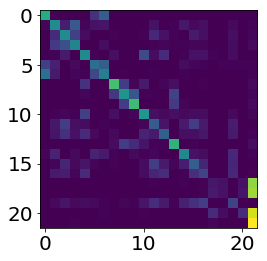

In [557]:
imshow(confusion_matrix(y_test, y_pred))

 and use classification_report to assess the model and clf.feature_importances_ to find the important features

In [560]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        10t       0.51      0.58      0.55       134
        14d       0.38      0.41      0.39       150
         1d       0.33      0.41      0.37       148
         2t       0.39      0.44      0.42       129
        30d       0.38      0.42      0.40       142
         7d       0.38      0.34      0.36       132
        ada       0.36      0.38      0.37       143
       afas       0.69      0.59      0.64       151
        exp       0.49      0.44      0.46       149
         ez       0.61      0.64      0.63       135
         ff       0.46      0.51      0.49       131
         mc       0.27      0.26      0.27       137
      month       0.35      0.28      0.31       138
         mr       0.57      0.60      0.58       137
        rfm       0.51      0.46      0.48       129
         rr       0.29      0.27      0.28       140
        sen       0.24      0.20      0.22       128
       spec       0.23      0.06      0.10   

## Build a model that uses as input features each time stamp (194 features) :


In [639]:
ts_ml_set = nonull_df.reset_index()\
    .merge(types.reset_index(), left_index=True, right_index=True)\
    .drop(labels=['index_x', 'index_y'], axis=1)\
    .rename(mapper={0: 'label'}, axis=1)
ts_ml_set.head()

,2010-05-23 00:00:00,2010-05-30 00:00:00,2010-06-06 00:00:00,2010-06-13 00:00:00,2010-06-20 00:00:00,2010-06-27 00:00:00,2010-07-04 00:00:00,2010-07-11 00:00:00,2010-07-18 00:00:00,2010-07-25 00:00:00,...,2013-12-08 00:00:00,2013-12-15 00:00:00,2013-12-22 00:00:00,2013-12-29 00:00:00,2014-01-05 00:00:00,2014-01-12 00:00:00,2014-01-19 00:00:00,2014-01-26 00:00:00,2014-02-02 00:00:00,label
0,3292.0,3429.0,3629.0,2808.0,3614.0,2601.0,2848.0,2798.0,2888.0,3591.0,...,2894.0,2679.0,3337.0,3599.0,3273.0,3418.0,3746.0,3406.0,3217.0,10t
1,110.0,92.0,102.0,79.0,93.0,74.0,72.0,92.0,97.0,95.0,...,167.0,160.0,180.0,204.0,166.0,191.0,212.0,209.0,211.0,14d
2,7.0,6.0,13.0,7.0,5.0,7.0,7.0,6.0,3.0,4.0,...,17.0,18.0,20.0,19.0,13.0,19.0,26.0,20.0,22.0,1d
3,41.0,51.0,47.0,37.0,50.0,43.0,44.0,32.0,43.0,57.0,...,18.0,24.0,20.0,25.0,29.0,31.0,28.0,24.0,22.0,2t
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,...,1.0,1.0,10.0,8.0,6.0,5.0,5.0,6.0,0.0,30d


In [641]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(
    ts_ml_set.iloc[:, :-1] # ts'
    , ts_ml_set.iloc[:, -1] # label
    , test_size=0.33
    , random_state=42
    , shuffle=True
)

In [642]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6146, 194), (3028, 194), (6146,), (3028,))

In [643]:
model = rfc().fit(X_train, y_train)
y_pred = model.predict(X_test)

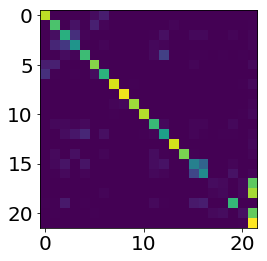

In [644]:
imshow(confusion_matrix(y_test, y_pred))

In [645]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.80      0.89      0.84       151
        14d       0.68      0.80      0.74       134
         1d       0.61      0.68      0.64       139
         2t       0.62      0.61      0.62       126
        30d       0.75      0.70      0.72       146
         7d       0.84      0.79      0.81       154
        ada       0.78      0.78      0.78       123
       afas       0.98      0.96      0.97       146
        exp       0.98      0.99      0.99       147
         ez       0.99      0.95      0.97       134
         ff       0.99      0.96      0.98       137
         mc       0.79      0.82      0.80       123
         mr       0.63      0.65      0.64       130
      month       0.99      0.98      0.98       142
        rfm       1.00      0.85      0.92       140
         rr       0.55      0.45      0.49       146
        sen       0.52      0.58      0.55       125
       spec       0.45      0.04      0.07   

/nfshome/shy256/.conda/envs/tf/lib/python3.5/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 22, does not match size of target_names, 23
  .format(len(labels), len(target_names))


In [ ]:
## End of Notebook